# Lottery number 

## 0. Preparation
### 0.1 Imports

In [145]:
import argparse, configparser, copy, csv, datetime
import matplotlib.pyplot as plt
plt.rc('font', family='Cascadia Code PL')
plt.rcParams['figure.figsize'] = (16, 6)

import numpy as np

import pandas as pd
#pd.set_option('display.max_rows', 8)

from sklearn.model_selection import train_test_split

### 0.2 Arguments

In [146]:
# =================================================
# Parse arguments
parser = argparse.ArgumentParser()
# Config
parser.add_argument("-c", "--config_file", type=str, help='Config file for the lottery type (default: nil)')
# Debug and log
parser.add_argument('-d', '--debug', action='store_true', help='Debug mode (default: false)')
parser.add_argument('-l', '--log_file_name', type=str, default=datetime.date.today().strftime('%Y%m')+'.log',
        help='Log file name (default: %Y%m.log)')
# Lottery game definition
parser.add_argument('-L', '--lottery_max_number', type=int, default=31,
        help='Lottery game max numbers. (default: 31)')
parser.add_argument('-p', '--pick', type=int, default=5,
        help='Number of pick in one game (default: 5)')
# Detail of input data
parser.add_argument('-f', '--file_path', type=str, help='CSV file path (default: nil)')
parser.add_argument('-r', '--remove_lines', type=int, default=0,
        help='Remove unnecessary header lines in csv file (default: 0)')
parser.add_argument('-a', '--appearance_first_number_order', type=int, default=0,
        help='Order of First number appears on the row in csv file (default: 0)')
parser.add_argument('--perge_data_percentage', type=float, default=0.0,
        help='Perge older data to improve accuracy. 0.0 < Input in percentage < 1.0 (default: 0.0)')
# For formating data
parser.add_argument('--test_size', type=float, default=0.1,
        help='Test size is for validation. 0.0 < Input in percentage < 1.0 (default: 0.1)')
parser.add_argument('--random_state', type=int, default=0,
        help='Random state is used when split data for validation (default: 0)')
parser.add_argument('--batch_size', type=int, default=1,
        help='How many samples per batch to load (default: 1)')
# For training
parser.add_argument('-e', '--epochs', type=int, default=50,
        help='How many times to train (default: 50)')
# Others
parser.add_argument('--random_seed', type=int, default=7, help='Random seed. Default: 7')
parser.add_argument('--np_random_seed', type=int, default=7, help='Random seed. Default: 7')

args = parser.parse_args()

### 0.3 Read config

In [147]:
%cat '../data/jpn/loto7/loto7.conf'

args.config_file = '../data/jpn/loto7/loto7.conf'

# Read from config file and overwrite
if args.config_file:
    config = configparser.ConfigParser()
    config.read(args.config_file)
    defaults = {}
    defaults.update(dict(config.items("Defaults")))
    parser.set_defaults(**defaults)
    args = parser.parse_args() # Overwrite arguments

[Defaults]
lottery_max_number = 37
pick = 7

file_path = data/jpn/loto7/loto7_utf-8.csv
remove_lines = 1
appearance_first_number_order = 2
perge_data_percentage = 0.3

batch_size = 32


## 1. Data
### 1.1 Read lottery number csv

In [148]:
data = pd.read_csv('../data/jpn/loto7/loto7_utf-8.csv')
data

,開催回,日付,第1数字,第2数字,第3数字,第4数字,第5数字,第6数字,第7数字,BONUS数字1,...,4等口数,5等口数,6等口数,1等賞金,2等賞金,3等賞金,4等賞金,5等賞金,6等賞金,キャリーオーバー
0,1,2013/04/05,7,10,12,17,23,28,34,3,...,8254,115022,189593,301716500,4144600,828900,9800,1700,900,0
1,2,2013/4/12,20,24,29,31,33,34,35,32,...,3631,67155,122990,0,27968500,1864500,18900,2500,1200,247506600
2,3,2013/4/19,2,7,8,11,14,23,31,5,...,9957,147796,252702,0,8717200,839700,10700,1700,900,646583065
3,4,2013/4/26,12,13,22,23,24,28,29,2,...,7217,127060,217162,0,22730100,1446400,15500,2100,1100,1055636845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,431,2021/8/6,7,11,12,17,19,20,26,2,...,7134,107170,200427,0,5654000,1007400,9100,1400,900,1739327690
431,432,2021/8/13,5,10,13,24,29,30,35,21,...,7355,116284,205507,0,6875000,726400,9200,1400,1000,2147483647
432,433,2021/8/20,14,17,20,25,32,33,36,10,...,7787,115046,186504,924772200,18051800,607500,9500,1500,1200,0
433,434,2021/8/27,10,11,12,17,29,34,37,26,...,5217,84556,150152,380539500,6231100,752000,9800,1400,1000,0


In [149]:
data.describe()

,開催回,第1数字,第2数字,第3数字,第4数字,第5数字,第6数字,第7数字,BONUS数字1,BONUS数字2,...,4等口数,5等口数,6等口数,1等賞金,2等賞金,3等賞金,4等賞金,5等賞金,6等賞金,キャリーオーバー
count,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.00000,434.000000,...,434.000000,434.000000,434.000000,4.340000e+02,4.340000e+02,4.340000e+02,434.000000,434.000000,434.000000,4.340000e+02
mean,217.500000,5.062212,9.486175,14.262673,18.974654,24.006912,28.746544,33.184332,13.06682,25.391705,...,6676.513825,103677.509217,177199.806452,2.678137e+08,1.169983e+07,9.659836e+05,11415.437788,1740.322581,1015.437788,6.612456e+08
std,125.429263,3.814195,4.875924,5.504576,5.828718,5.190812,4.651881,3.585077,8.79994,8.677625,...,1822.660282,24551.048498,40692.251647,3.512387e+08,7.126131e+06,2.893306e+05,2572.005340,332.268968,92.271399,7.274338e+08
min,1.000000,1.000000,2.000000,3.000000,5.000000,9.000000,15.000000,20.000000,1.00000,3.000000,...,3423.000000,58886.000000,104129.000000,0.000000e+00,1.315000e+05,2.081000e+05,5900.000000,1200.000000,800.000000,0.000000e+00
25%,109.250000,2.000000,6.000000,10.000000,15.000000,20.000000,25.250000,31.000000,6.00000,20.000000,...,5333.250000,85187.500000,146473.500000,0.000000e+00,7.238750e+06,7.542000e+05,9400.000000,1400.000000,1000.000000,0.000000e+00
50%,217.500000,4.000000,9.000000,14.000000,19.000000,24.000000,30.000000,34.000000,11.50000,27.000000,...,6423.000000,99305.500000,172374.500000,0.000000e+00,1.004545e+07,9.277500e+05,11200.000000,1800.000000,1000.000000,3.652741e+08
75%,325.750000,7.000000,13.000000,18.000000,23.000000,28.000000,32.000000,36.000000,19.00000,33.000000,...,7757.250000,117945.250000,202952.500000,4.835114e+08,1.346058e+07,1.149650e+06,13100.000000,2000.000000,1100.000000,1.133601e+09
max,434.000000,20.000000,25.000000,31.000000,34.000000,35.000000,36.000000,37.000000,36.00000,37.000000,...,13086.000000,180209.000000,306651.000000,1.000000e+09,7.346820e+07,1.864500e+06,18900.000000,2500.000000,1200.000000,2.147484e+09


### 1.2 Take only picked numbers

In [150]:
data_selected = pd.DataFrame(data.iloc[:, 2:9])
data_selected.columns = ['p'+str(i) for i in range(args.pick) ]
data_selected

,p0,p1,p2,p3,p4,p5,p6
0,7,10,12,17,23,28,34
1,20,24,29,31,33,34,35
2,2,7,8,11,14,23,31
3,12,13,22,23,24,28,29
...,...,...,...,...,...,...,...
430,7,11,12,17,19,20,26
431,5,10,13,24,29,30,35
432,14,17,20,25,32,33,36
433,10,11,12,17,29,34,37


### 1.3 Visualization

<AxesSubplot:title={'center':'Distrubution each picks'}, ylabel='Frequency'>

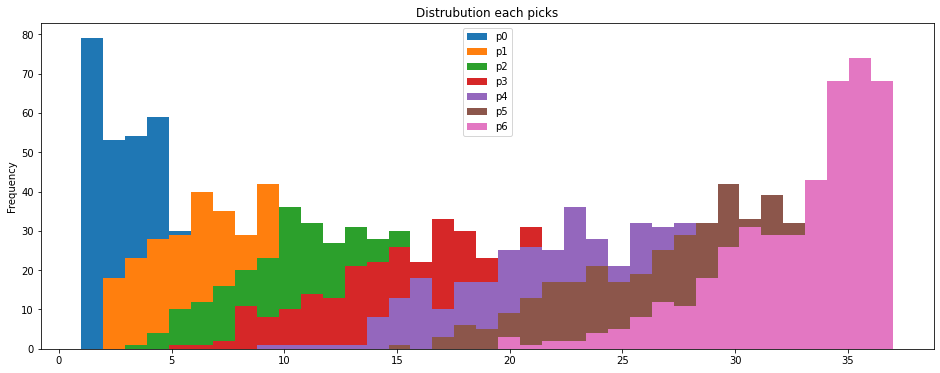

In [151]:
data_selected.plot(kind='hist', bins=37, title='Distrubution each picks')

<AxesSubplot:title={'center':'Distrubution all'}, ylabel='Frequency'>

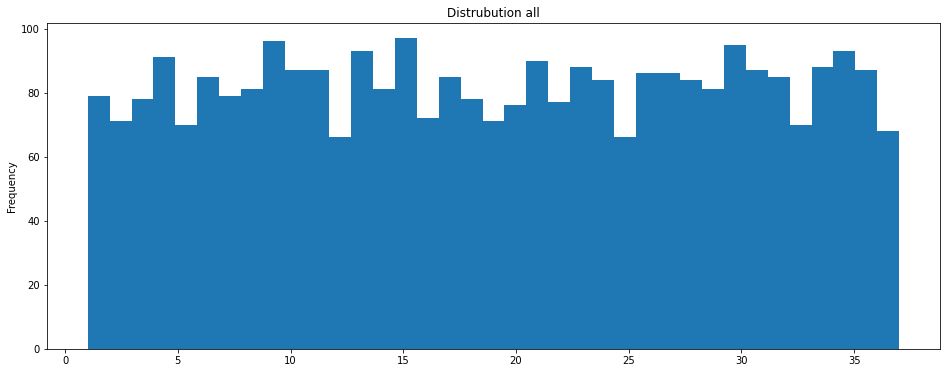

In [152]:
data_selected.stack().reset_index(drop=True).plot(kind='hist', bins=37, title='Distrubution all')

## 2. Data preparatino
### 2.1 One-hot

In [153]:
# ont-hot
def oneHot(list_2d):
    data_list = []
    for row in list_2d:
        bins = [ 0 for i in range(args.lottery_max_number) ]
        for e in row:
            bins[int(e)-1] = 1
        data_list.append( bins )
    return np.array(data_list)

columns = [ str(i) for i in range(args.lottery_max_number) ]
data_one_hot = pd.DataFrame(oneHot(data_selected.values), columns=columns)
data_one_hot

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,0,0
2,0,1,0,0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
431,0,0,0,0,1,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0
432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
433,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1


### 2.2 Create dataset

In [154]:
X = data_one_hot.drop(data_one_hot.tail(1).index)
y = data_one_hot.drop(data_one_hot.head(1).index)
print(X.shape)
print(y.shape)

(433, 37)
(433, 37)


In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

print( X_train.shape )
print( y_train.shape )
print( X_test.shape )
print( y_test.shape )

(346, 37)
(346, 37)
(87, 37)
(87, 37)


## 3. Models

### 3.1 Define Models

In [157]:
#from sklearn.multioutput import MultiOutputRegressor
#from sklearn.ensemble import GradientBoostingRegressor

from sklearn.multioutput import MultiOutputClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

classifiers = {
    'GaussianNB': MultiOutputClassifier(GaussianNB()),
    'LogisticRegression': MultiOutputClassifier(LogisticRegression(
        multi_class='multinomial'
    )),
    'KNeighborsClassifier': MultiOutputClassifier(KNeighborsClassifier()),
    'MLPClassifier': MultiOutputClassifier(MLPClassifier(max_iter=1000)),
    'RandomForestClassifier': MultiOutputClassifier(RandomForestClassifier()),
    'SVC': MultiOutputClassifier(SVC()),
}

### 3.2 Training

In [158]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    print('classifier: ', key, 'score: ', classifier.score(X_train, y_train) )

classifier:  GaussianNB score:  0.0
classifier:  LogisticRegression score:  0.0
classifier:  KNeighborsClassifier score:  0.0
classifier:  MLPClassifier score:  1.0
classifier:  RandomForestClassifier score:  1.0
classifier:  SVC score:  0.0


### 3.3 Evaluation

In [159]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

for key, classifier in classifiers.items():
    #if key == 'MultiOutputRegressor_GradientBoostingRegressor':
    #    continue
    y_pred = classifier.predict(X_test)
    print('classifier: ', key)
    #print( multilabel_confusion_matrix(y_test, y_pred) )
    #print( classification_report(y_test, y_pred) )
    # get tok k
    y_pred = y_pred.argsort()[:, -args.pick:]
    # back to real number
    y_pred += 1
    # one-hot
    y_pred = oneHot(y_pred)
    # Get True counts in all
    y_pred = np.sum( (y_pred == y_test), axis=1)
    # Get wrong counts
    y_pred = (args.lottery_max_number - y_pred)/2
    # Get correct counts
    y_pred = args.pick - y_pred
    # Calculate accuracy
    accuracy = y_pred.sum()/(args.pick * y_pred.count())
    print('accuracy: ', round(accuracy, 4) )

classifier:  GaussianNB
accuracy:  0.1823
classifier:  LogisticRegression
accuracy:  0.2036
classifier:  KNeighborsClassifier
accuracy:  0.197
classifier:  MLPClassifier
accuracy:  0.1954
classifier:  RandomForestClassifier
accuracy:  0.1888
classifier:  SVC
accuracy:  0.1856


## 4. Predict next picks

In [160]:
print('last picks: ')
print(data_selected.tail())

n_last = data_one_hot.tail(1).index.tolist()[0]
print('predict #', n_last+1+1, ', picks: ') # becareful! index starts from 0

X_last = np.array([data_one_hot.iloc[-1]])

y_pred_one_hot = np.array([ 0 for i in range(args.lottery_max_number) ])
for key, classifier in classifiers.items():
    y_pred = classifier.predict(X_last)
    # get tok k
    y_pred = y_pred.argsort()[:, -args.pick:]
    # back to real number
    y_pred += 1
    # sort
    y_pred.sort()
    print('classifier: ', key.rjust(25), '-->', y_pred[0])
    # one-hot
    y_pred_one_hot += oneHot(y_pred)[0]

# Get top k
y_final = y_pred_one_hot.argsort()[-args.pick:]
# back to real number
y_final += 1
# sort
y_final.sort()
print('final picks: ', y_final)

last picks: 
     p0  p1  p2  p3  p4  p5  p6
429   2  12  17  24  28  30  32
430   7  11  12  17  19  20  26
431   5  10  13  24  29  30  35
432  14  17  20  25  32  33  36
433  10  11  12  17  29  34  37
predict # 435 , picks: 
classifier:                 GaussianNB --> [ 8 10 20 21 24 26 29]
classifier:         LogisticRegression --> [ 8 10 13 14 15 16 37]
classifier:       KNeighborsClassifier --> [10 13 14 15 16 24 37]
classifier:              MLPClassifier --> [ 7 10 14 20 24 29 37]
classifier:     RandomForestClassifier --> [12 13 14 15 16 18 37]
classifier:                        SVC --> [12 13 14 15 16 18 37]
final picks:  [10 13 14 15 16 24 37]


## TODO
- remove past case

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

from sklearn.ensemble import GradientBoostingRegressor

mor_gbr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=1000, random_state=0))
mor_gbr.fit(X_train, y_train)
mor_gbr.score(X_train, y_train)